# bin size vs performance triangle plot

In [5]:
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
import tfr_evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
bin_run = {256: 'paper_runs/basenji/binloss_basenji/run-20210923_162932-56p3xy2p',
             1: 'paper_runs/basenji/binloss_basenji/run-20210922_044222-5ueie0zy',
             2048: 'paper_runs/basenji/binloss_basenji/run-20210920_085441-14shgpx1',
             1024: 'paper_runs/basenji/binloss_basenji/run-20210920_082433-1ka588yc',
             512: 'paper_runs/basenji/binloss_basenji/run-20210920_075434-wilgxp1a',
             128: 'paper_runs/basenji/binloss_basenji/run-20210920_034502-n8axwb3r',
             64: 'paper_runs/basenji/binloss_basenji/run-20210920_034501-7tftpu54',
             32: 'paper_runs/basenji/binloss_basenji/run-20210920_034449-8p51o3ho'}
# get datasets
testset, targets, target_dataset_idr = tfr_evaluate.collect_datasets()

# get performance metrics for various evaluation bin sizes 
result_path = 'traingle_plot.txt'
bin_sizes = [1, 32, 64, 128, 256, 512, 1024, 2048]
if os.path.isfile(result_path):
    with open(result_path, 'r') as f:
        padded_values = json.loads(f.read())
else:
    performance_per_resolution = []
    for raw_bin_size in bin_run.keys():
        model, _ = tfr_evaluate.read_model(bin_run[raw_bin_size])
        all_true, all_pred = tfr_evaluate.get_true_pred(model, raw_bin_size, testset)
        for eval_bin_size in bin_sizes:
            if eval_bin_size>=raw_bin_size:
                print(raw_bin_size, '--->', eval_bin_size)
                true_for_eval = tfr_evaluate.change_resolution(all_true, raw_bin_size, eval_bin_size)
                pred_for_eval = tfr_evaluate.change_resolution(all_pred, raw_bin_size, eval_bin_size)
                performance = tfr_evaluate.get_performance(true_for_eval, pred_for_eval, targets, 'whole')
                performance_per_resolution.append([raw_bin_size, eval_bin_size] + list(performance.mean().values))
    metric_label = {'pr_corr':'Pearson r'}
    metric = list(metric_label.keys())[0]
    label = metric_label[metric]
    sorted_personr = pd.DataFrame(performance_per_resolution, columns=['train', 'eval']+list(performance.columns[:-1].values)).sort_values(['train', 'eval'])[['train', 'eval', metric]]

    padded_values = []
    for train_bin, df in sorted_personr.groupby('train'):
        pr_values = list(df[metric].values)
        add_N = len(bin_sizes)-len(pr_values)
        if add_N>0:
            pr_values = [np.nan for n in range(add_N)]+pr_values
        padded_values.append(pr_values)
    with open(result_path, 'w') as f:
        f.write(json.dumps(padded_values))

Text(33.0, 0.5, 'Training bin size')

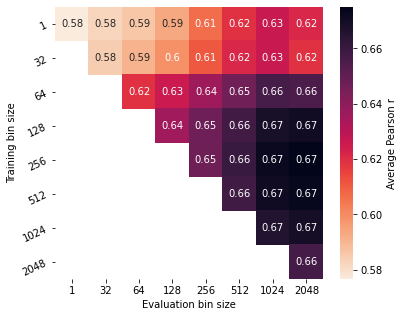

In [21]:
fig, ax = plt.subplots(figsize=[6, 5])
 
# creating mask
mask = np.triu(np.ones_like(padded_values), 1).T
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(padded_values, cmap="rocket_r", annot=True, mask=mask, 
                       cbar_kws={'label': "Average "+label}, ax=ax)
dataplot.set_xticks([r+0.5 for r in range(len(bin_sizes))]) 
dataplot.set_yticks([r+0.5 for r in range(len(bin_sizes))]) 
dataplot.set_xticklabels(bin_sizes) 
dataplot.set_yticklabels(bin_sizes, rotation=25) 
dataplot.set_xlabel('Evaluation bin size')
dataplot.set_ylabel('Training bin size')

# Loss and bin size Pearson's r

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
summary_performance = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/binloss_basenji.csv')


average_summary_performance = summary_performance[(summary_performance['pred type'] == 'scaled')&
                                                  (summary_performance['eval type'] == 'whole')
                                                  ].groupby(['bin_size', 'loss_fn']).mean().reset_index()

loss_name_subs = {'basenjipearsonr': 'pearson r', 'mse': 'MSE',
                  'multinomialnll_mse_reg':'multinomial NLL + MSE',
                 'poisson':'poisson NLL', 'pearsonr_mse': 'pearson r + MSE'}

average_summary_performance['loss'] = [loss_name_subs[l] for l in average_summary_performance['loss_fn'].values]

(1.12, 1.75)

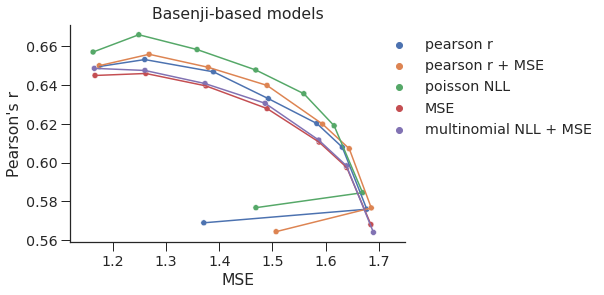

In [3]:
sns.set(font_scale=1.3)  
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True


df = average_summary_performance
lines = sns.lineplot(data=df.sort_values('bin_size'), x='mse', 
                     y='pr_corr', hue='loss', sort=False, legend=False)

points = sns.scatterplot(data=average_summary_performance, x='mse', y='pr_corr', hue='loss', 
                         ax=lines, legend='full')

points.legend(frameon=False, bbox_to_anchor=(0.9,1))
plt.title('Basenji-based models')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel('Pearson\'s r')
plt.xlabel('MSE')
plt.xlim(1.12,1.75)


# Training set threshold

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
trainset_results = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/trainset_threshold.csv')

dataset_label = {'peak_centered': 'peak centered',
                'random_chop': 'threshold=2',
                 'threshold_4':'threshold=4',
                 'threshold_6':'threshold=6',
                 'threshold_8':'threshold=8',
                'threshold_10':'threshold=10'}
trainset_results['dataset'] = [dataset_label[d.split('/i_3072')[0].split('/')[-1]] for d in trainset_results['data_dir'].values]

testset_type='whole'
whole_raw_results = trainset_results[(trainset_results['pred type']=='raw')&
                                    (trainset_results['eval type']==testset_type)]

metrics = whole_raw_results.groupby(['bin_size', 'dataset']).mean().reset_index()
descriptions = whole_raw_results.iloc[:,8:]
avg_metrics_per_run = metrics.merge(descriptions,how='left', on=['bin_size', 'dataset']).drop_duplicates(subset=['bin_size','dataset','eval type'])


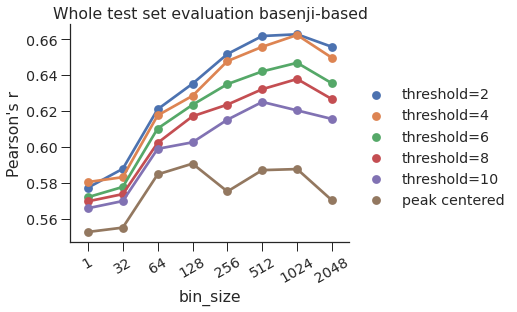

In [6]:
sns.set(font_scale=1.3)  
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
fig, ax = plt.subplots(1,1, figsize=[5,4])
testset_types = ['whole', 'idr']
titles = ['Whole', 'IDR']
metric = {'Pearson\'s r':'pr_corr'}

sns.pointplot(data=avg_metrics_per_run, 
              x='bin_size', y=list(metric.values())[0], hue='dataset', ax=ax, 
              hue_order=['threshold=2', 'threshold=4', 'threshold=6', 'threshold=8', 
                         'threshold=10','peak centered'] )

ax.set_title('Whole test set evaluation basenji-based')
plt.legend(loc='lower center',bbox_to_anchor=(1.3,0.1),frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel(list(metric.keys())[0]);

plt.xticks(rotation=30);

# Test set threshold

In [1]:
import tfr_evaluate
import util
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import embed
import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
run_path = glob.glob('paper_runs/basenji/*/*c7k7jwqa')[0]
model, bin_size = tfr_evaluate.read_model(run_path)
testset, targets = tfr_evaluate.collect_whole_testset(coords=True)
_,np_x, np_y = util.convert_tfr_to_np(testset, 3)

In [15]:
%%time
test_range = range(25)
pr_filename = 'pr_df.csv'
pos_filename = 'pos_df.csv'
if os.path.isfile(pr_filename) and os.path.isfile(pos_filename):
    pr_df = pd.read_csv(pr_filename, index_col='Unnamed: 0')
    pos_df = pd.read_csv(pos_filename, index_col='Unnamed: 0')
else:
    thresh_pr_dict = {}
    thresh_pos_dict = {}
    
    for thresh in tqdm(test_range):
        bool_mask = np_y.max(axis=1)>thresh # above threshold in any 1 cell_line
        thresh_inds = np.unique(np.argwhere(bool_mask).flatten())
        filtered_y = np_y[thresh_inds,:,:]

        filtered_x = np_x[thresh_inds,:,:]    
        N_seqs = thresh_inds.shape[0]
        binned_y = filtered_y.reshape(N_seqs, 2048//bin_size, bin_size, len(targets)).mean(axis=2)
        all_preds = embed.predict_np(filtered_x, model, batch_size=256, reshape_to_2D=False)
        thresh_pr_dict[thresh] = metrics.get_correlation_per_seq(binned_y, all_preds)
        thresh_pos_dict[thresh] = (filtered_y.max(axis=1)>thresh).sum(axis=0)
    pr_df = pd.DataFrame(thresh_pr_dict).T
    pos_df = pd.DataFrame(thresh_pos_dict).T
    pr_df.to_csv(pr_filename)
    pos_df.to_csv(pos_filename)

CPU times: user 9.06 ms, sys: 0 ns, total: 9.06 ms
Wall time: 7.45 ms


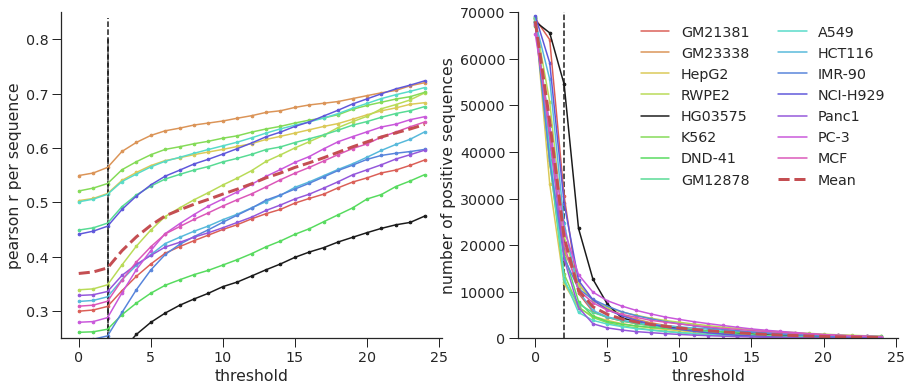

In [16]:
fig, axs = plt.subplots(1,2, figsize=[15,6])
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
sns.set_palette('hls', 15)
for cell_line in range(15):
    for d,df in enumerate([pr_df, pos_df]):
        if cell_line == 4:
            axs[d].plot(test_range, df.iloc[:,cell_line], label = targets[cell_line], c='k')
            axs[d].scatter(test_range, df.iloc[:,cell_line], c='k', s=7)
        else:
            axs[d].plot(test_range, df.iloc[:,cell_line], label = targets[cell_line])
            axs[d].scatter(test_range, df.iloc[:,cell_line], s=7)
axs[0].plot(test_range, pr_df.mean(axis=1), linewidth=3, linestyle='--', color='r', label='Mean')
axs[1].plot(test_range, pos_df.mean(axis=1), linewidth=3, linestyle='--', color='r', label='Mean')
axs[0].vlines(2, 0,0.8, linestyles='--',colors ='k')
axs[0].vlines(2, axs[0].get_ylim()[0], axs[0].get_ylim()[1], linestyles='--',colors ='k')
axs[1].vlines(2, axs[1].get_ylim()[0], axs[1].get_ylim()[1], linestyles='--',colors ='k')
axs[0].set_ylim(0.25,0.85)
axs[1].set_ylim(0,70000)
axs[1].legend(loc="upper right", bbox_to_anchor=(1,1), ncol=2,frameon=False)
axs[0].set_xlabel('threshold')
axs[1].set_xlabel('threshold')
axs[0].set_ylabel('pearson r per sequence')
axs[1].set_ylabel('number of positive sequences')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
# axs[0].set_xticks(range(0,n_points,4));
# axs[1].set_xticks(range(0,n_points,4));
plt.savefig('thresh_vs_perf_2.svg', bbox_inches='tight')

# Augmentation

In [1]:
import tensorflow as tf
import h5py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

In [2]:
#Read performance eval result and model metadata
performance_bpnet = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/augmentation_48.csv')
performance_basenji = pd.read_csv('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/augmentation_basenji.csv')

performance_whole = pd.concat([performance_bpnet, performance_basenji])

In [3]:
augm_dict = {('False', False): 'None', 
                 ('r_crop', False): 'Shift', 
                 ('False', True): 'RC', 
                 ('r_crop', True): 'Shift + RC'}


# model_name = 'bpnet'
bin_size=128
title_str = 'bin size = {}'.format(bin_size)
whole_raw_performance = performance_whole[(performance_whole['pred type']=='raw')
                                          &(performance_whole['eval type']=='whole')
                                         &(performance_whole['bin_size']==bin_size)
                                         ]
descriptions = whole_raw_performance.iloc[:,7:]
avg_perf = whole_raw_performance.groupby('run_dir').mean().reset_index()
avg_perf_complete = avg_perf.merge(descriptions, how='left', left_on='run_dir',right_on='run_dir').drop_duplicates(subset='run_dir')


avg_perf_complete['dataset'] = ['peak centered' if 'peak' in d else 'random chop' for d in avg_perf_complete['data_dir']]
avg_perf_complete['augmentation type'] = [augm_dict[(c,r)] for (c,r) in zip(avg_perf_complete['crop'], avg_perf_complete['rev_comp_x'])]
avg_perf_complete = avg_perf_complete.sort_values('augmentation type')


In [4]:
model_name_dict = {'basenjimod':'basenji', 'basenji_w1_b64':'basenji'}
avg_perf_complete['model'] = [model_name_dict.get(m,m)+'\n'+avg_perf_complete['dataset'].values[i] for i,m in enumerate(avg_perf_complete['model_fn'].values)]


## Augmentaion vs. Performance

Text(0, 0.5, "Pearson's r")

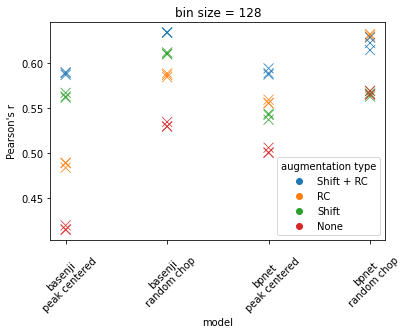

In [5]:
sns.scatterplot(data=avg_perf_complete.sort_values('model'), x='model', y='pr_corr', 
               hue='augmentation type', s=100, alpha=0.9, marker='x')
plt.xticks(rotation=45);
plt.title(title_str);
plt.ylabel('Pearson\'s r')

## Augmentation vs. Robustness

In [6]:
all_robustness_scores = []
for one_run_dir in avg_perf_complete['run_dir'].values:
    res_path = glob.glob('/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/robustness_test/*/*_{}/variance_of_preds.h5'.format(os.path.basename(one_run_dir)))
    assert len(res_path) == 1, 'Too many results!'
    robustness_result_path = res_path[0]
    h5_dataset = h5py.File(robustness_result_path, 'r')
    all_robustness_scores.append((h5_dataset['prediction_variance'][:]).mean())
    h5_dataset.close()
    
avg_perf_complete['robustness score'] = all_robustness_scores
avg_perf_complete = avg_perf_complete.sort_values('model')

Text(0, 0.5, 'Variation')

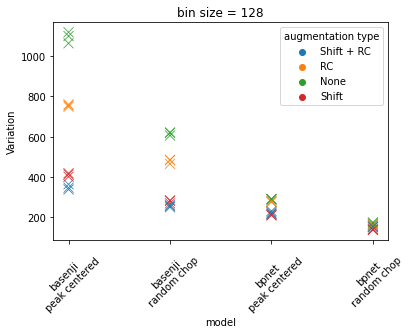

In [7]:
sns.scatterplot(data=avg_perf_complete.sort_values('model'), x='model', y='robustness score', 
               hue='augmentation type', s=100, alpha=0.9, marker='x')
plt.xticks(rotation=45);
plt.title(title_str);
plt.ylabel('Variation')

## Robustness vs. Performance

Text(0, 0.5, 'Pearons R')

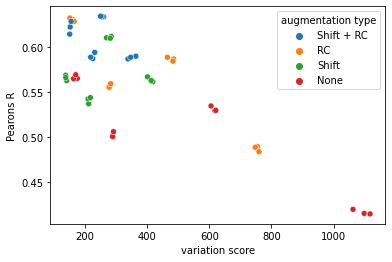

In [8]:
ax = sns.scatterplot(data = avg_perf_complete, x = 'robustness score', y= 'pr_corr',hue = 'augmentation type')
ax.set_xlabel('variation score')
ax.set_ylabel('Pearons R')

# Binary Model comparison

In [9]:
import pandas as pd
import seaborn as sns

In [10]:
df = pd.read_csv('/home/amber/QuantPred/datasets/binary/performance.csv',index_col = 0)

In [11]:
df

,model,chrom_auroc,chrome aupr,chr pearson r,peak auroc,peak aupr,peak pearson r,model type
0,rb_bi,0.856852,0.396623,0.404047,0.871567,0.692850,0.621246,Binary
1,basset_bi,0.780297,0.314453,0.380003,0.791483,0.585901,0.543745,Binary
2,rb_cov,0.879952,0.374688,0.551990,0.861478,0.663903,0.680437,Binary
3,basset_cov,0.733517,0.217261,0.378554,0.710897,0.498852,0.500808,Binary
4,bpnet_base,0.913938,0.514177,0.680115,0.838886,0.666111,0.670016,Quantiative
5,basenji_128,0.911800,0.487653,0.669393,0.835984,0.647946,0.652920,Quantiative
6,basenji_2k,0.895184,0.460035,0.656958,0.813998,0.627498,0.642830,Quantiative
7,rb_32,0.931332,0.561275,0.704188,0.868770,0.707412,0.698668,Quantiative
8,rb_base,0.920390,0.539550,0.696068,0.850259,0.683123,0.686464,Quantiative


Text(0.5, 1.0, 'performance on whole chromosome test set')

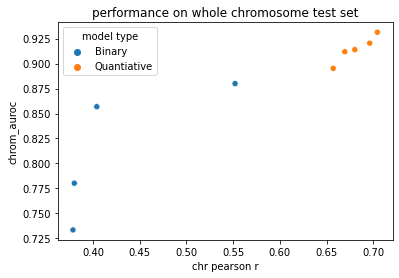

In [12]:
ax = sns.scatterplot(data = df, x = 'chr pearson r', y = 'chrom_auroc',hue = 'model type')
ax.set_title('performance on whole chromosome test set')

ax = sns.scatterplot(data = df, x = 'peak pearson r', y = 'peak auroc',hue = 'model type')
ax.set_title('performance on peak centered test set')

# VCF analysis

In [1]:
import h5py
import pandas as pd
import custom_fit
import numpy as np
import modelzoo
import explain
import tensorflow as tf
from tensorflow import keras
import glob
import h5py
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy
augm_dict = {('False', False): 'None', 
                 ('r_crop', False): 'Shift', 
                 ('False', True): 'RC', 
                 ('r_crop', True): 'Shift + RC'}

cagi_meta = '/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shush/CAGI5/final_cagi_metadata.csv'
eval_dir= '/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/model_evaluations/'

In [2]:
def compile_cagi_result(h5_dir,cagi_metadata):
    cagi_df = pd.read_csv(cagi_metadata)
    df_dict = {}
    for tf in cagi_df['8'].unique():
        df_dict[tf] = []
              
    VCFList = glob.glob(h5_dir)
    
    model = []
    average = []
    for vcf_result in VCFList:        
        f =  h5py.File(vcf_result, "r")
        total_diff = f['vcf_diff'][()]
        average_diff = np.mean(total_diff,axis = 1)
        f.close()

        #Pearson R evaluation
        temp_r = 0
        for tf in cagi_df['8'].unique():
            mask = (cagi_df['8'] == tf)
            cagi_diff = cagi_df[mask]['6']
            vcf_diff = average_diff[mask]
            vcf_diff = np.nan_to_num(vcf_diff)
            tf_r = stats.pearsonr(cagi_diff,vcf_diff)
            df_dict[tf].append(tf_r[0])
            temp_r += tf_r[0]

        average.append(temp_r/len(df_dict.keys()))

        file_name = vcf_result.split('/')[-1]
        run_name = file_name.split('.')[0]
        run_name = run_name.split('-')[-1]
        model.append(run_name)
    
    
    df_dict['model'] = model
    df_dict['Average'] = average
    
    vcf_df =pd.DataFrame.from_dict(df_dict)
    cols = vcf_df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    vcf_df = vcf_df[cols]
    vcf_df = vcf_df.set_index('model')
    return vcf_df

## VCF visualization heatmap + profile

In [2]:
%%time
vcf_data = '/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shush/CAGI5/CAGI_onehot.h5'
f =  h5py.File(vcf_data, "r")
alt_3k = f['alt'][()]
ref_3k = f['ref'][()]
f.close()

CPU times: user 2.03 ms, sys: 409 ms, total: 411 ms
Wall time: 408 ms


In [3]:
alt,ref = custom_fit.center_crop(alt_3k,ref_3k,2048)

In [3]:
cagi_df = pd.read_csv(cagi_meta,
                      index_col=0).reset_index()

In [6]:
model = modelzoo.load_model('./paper_runs/new_models/32_res/run-20211023_095136-to28llil',compile = True)

/home/amber/QuantPred/modelzoo.py:879: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(config_file)


In [7]:
vcf_result = '/home/amber/QuantPred/datasets/VCF/CAGI_results/new_model/run-20211023_095136-to28llil.h5'
f =  h5py.File(vcf_result, "r")
total_diff = f['vcf_diff']
average_diff = np.mean(total_diff,axis = 1)
f.close()

/home/amber/QuantPred/explain.py:456: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (20,2))


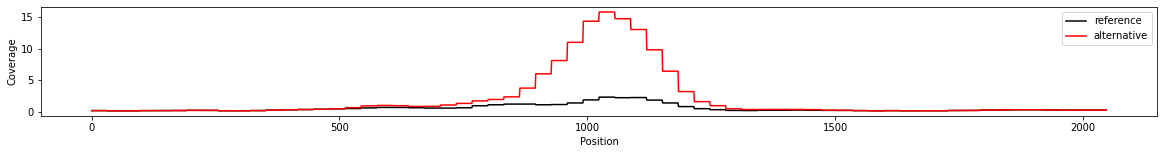

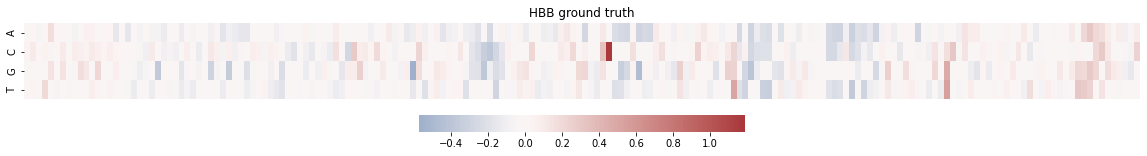

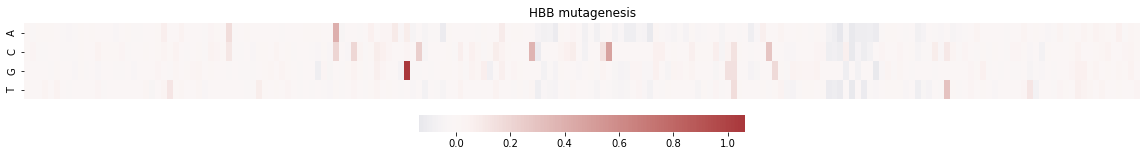

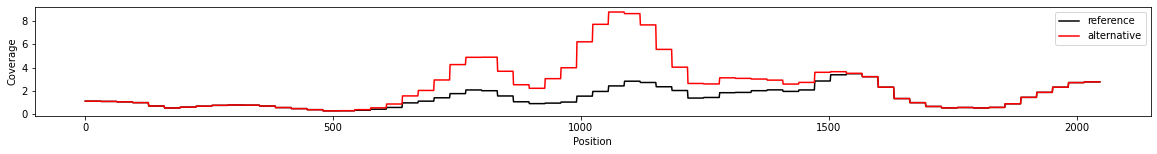

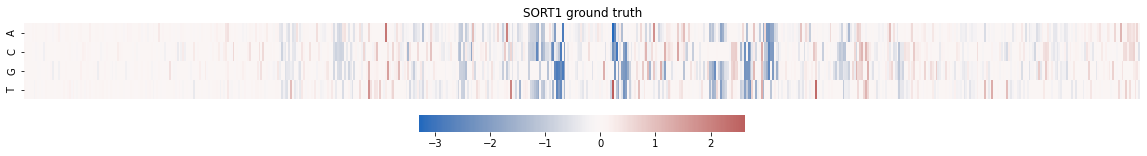

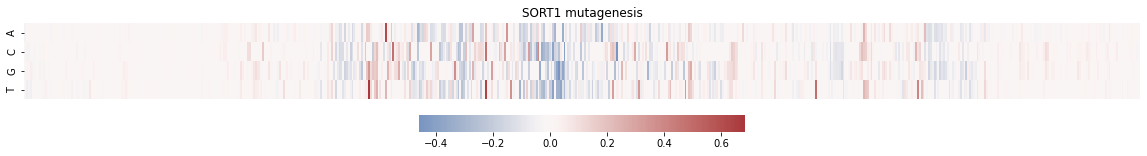

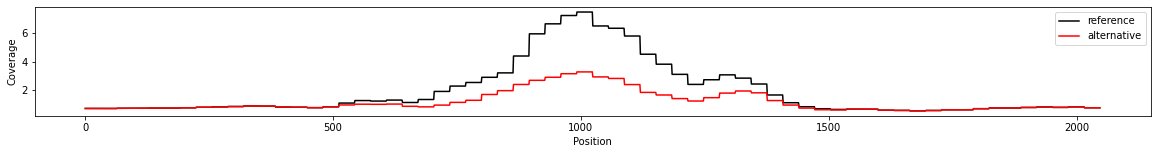

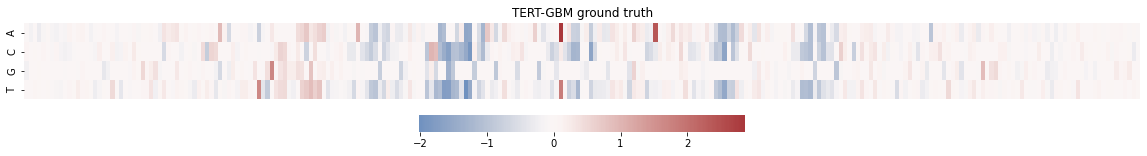

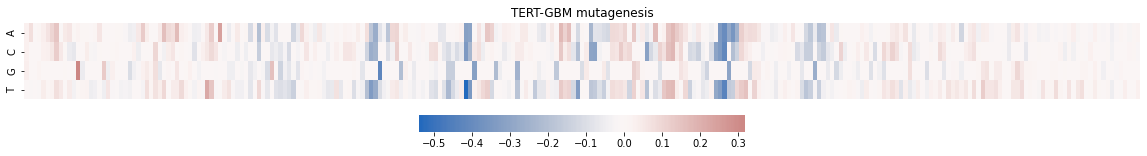

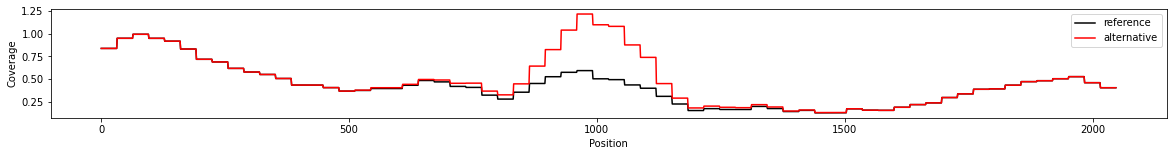

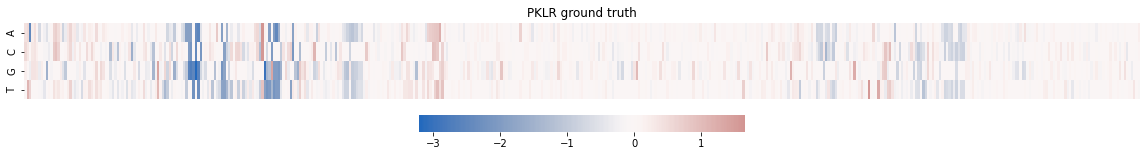

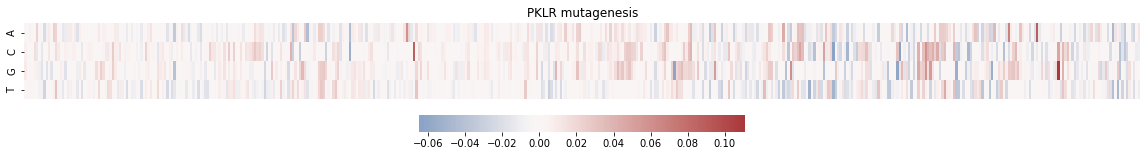

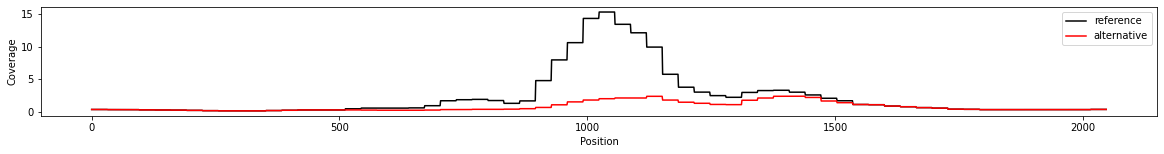

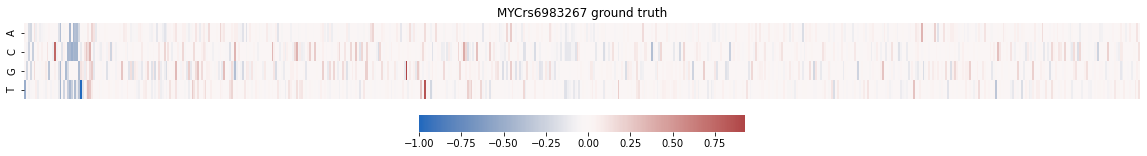

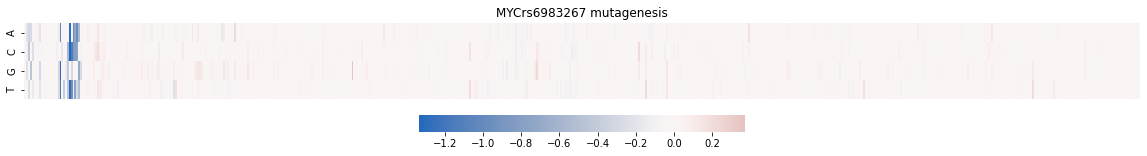

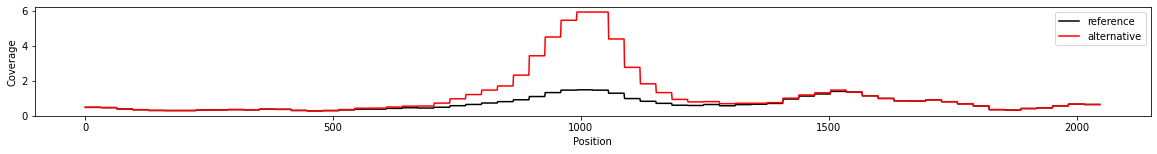

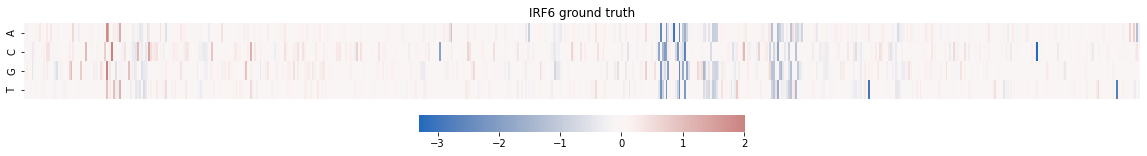

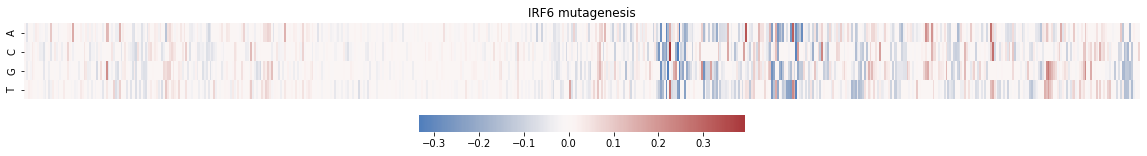

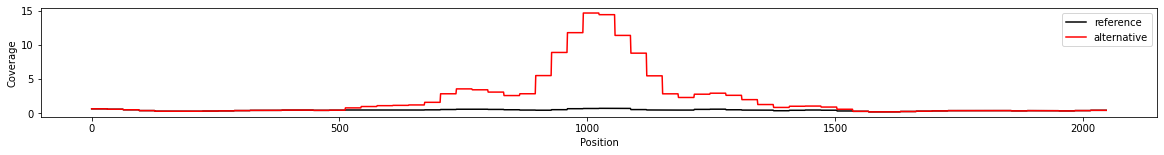

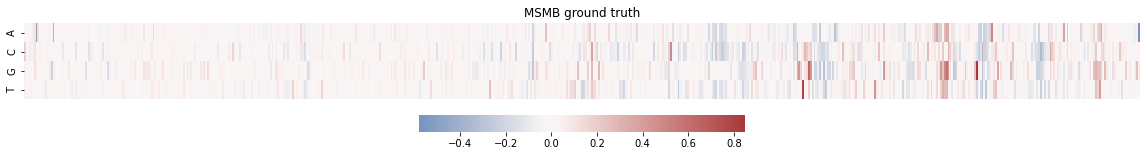

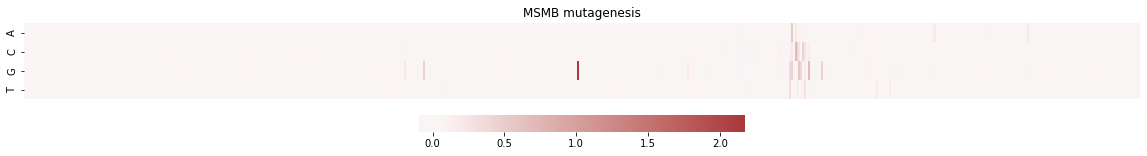

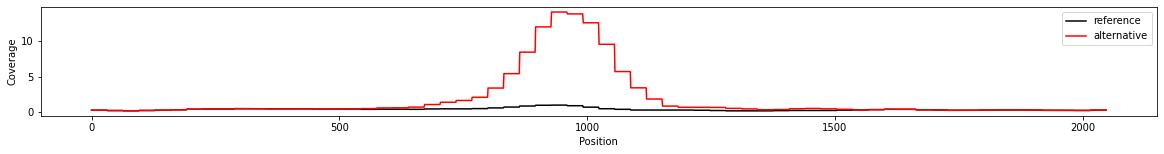

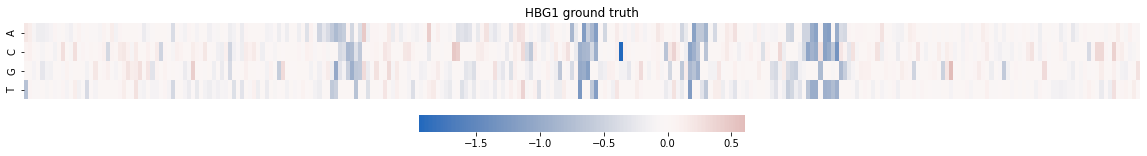

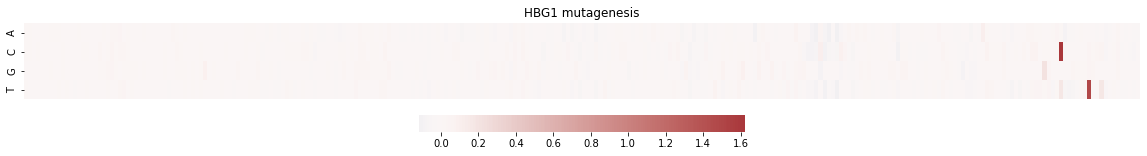

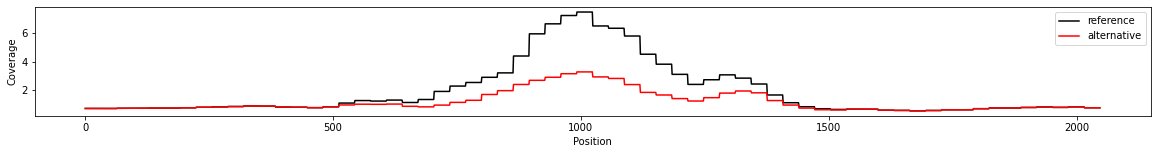

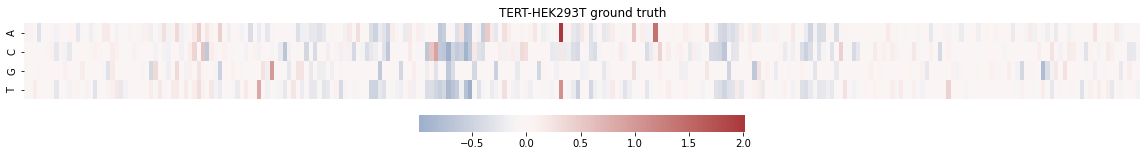

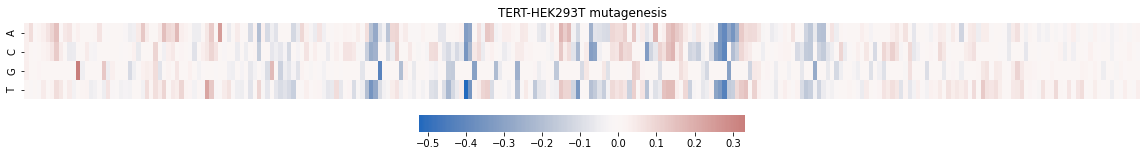

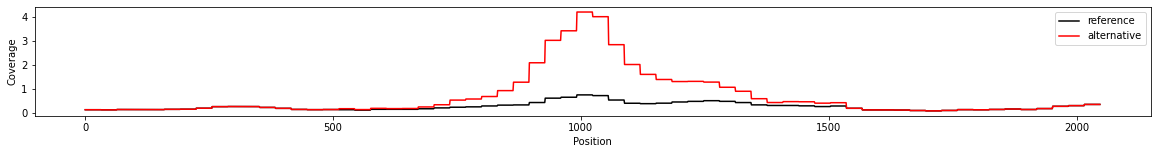

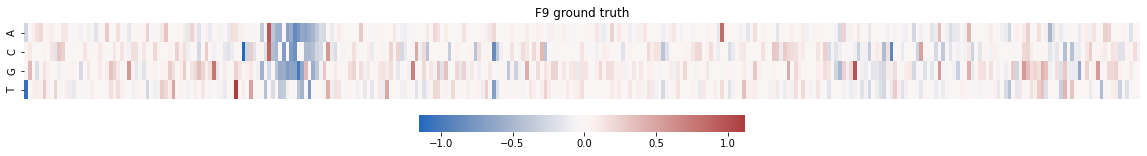

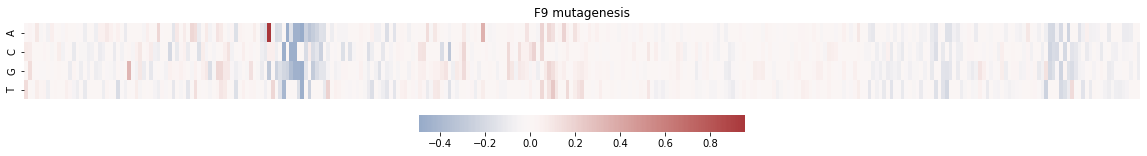

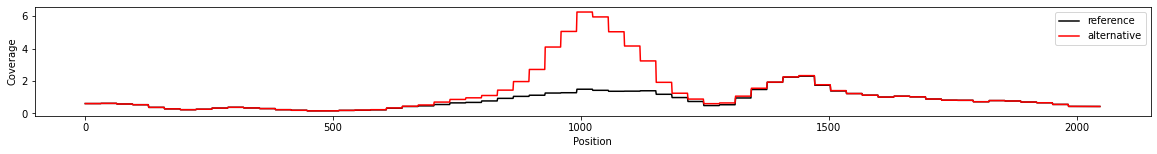

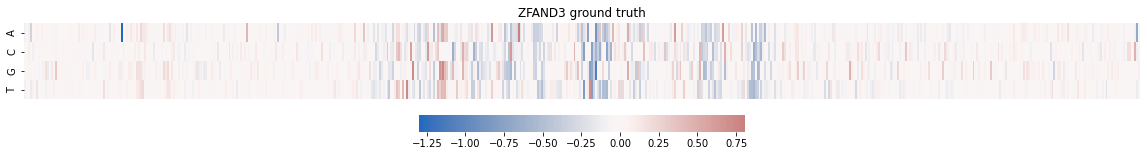

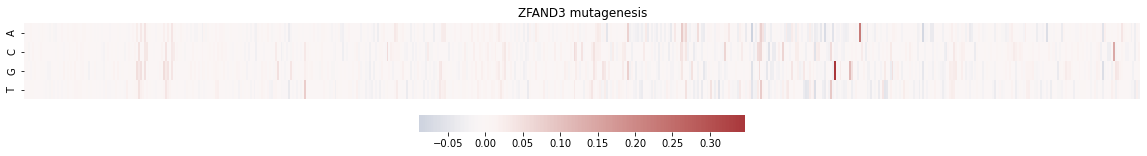

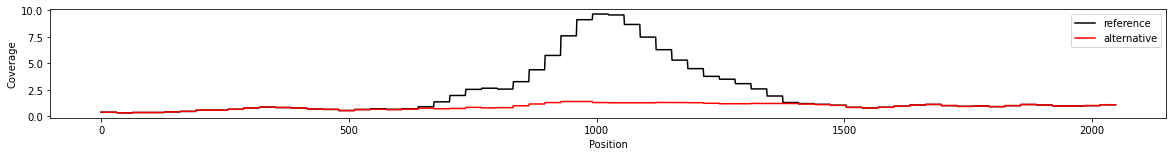

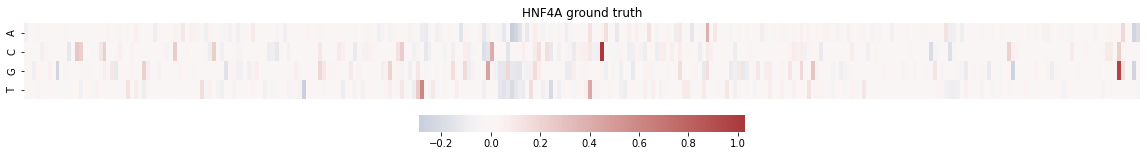

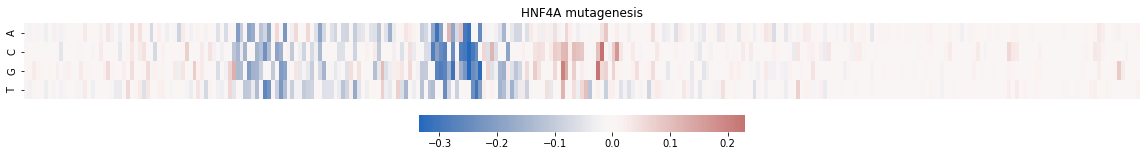

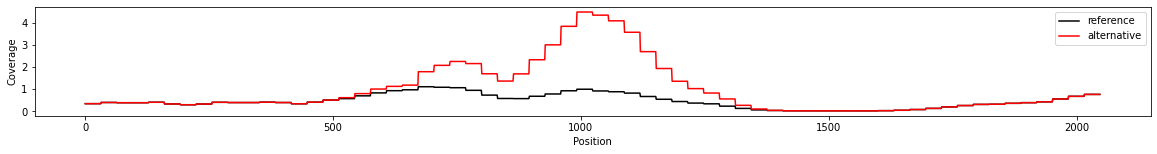

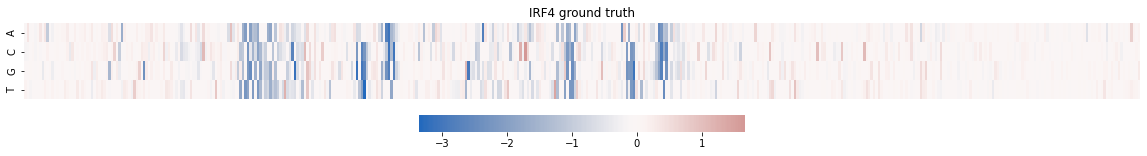

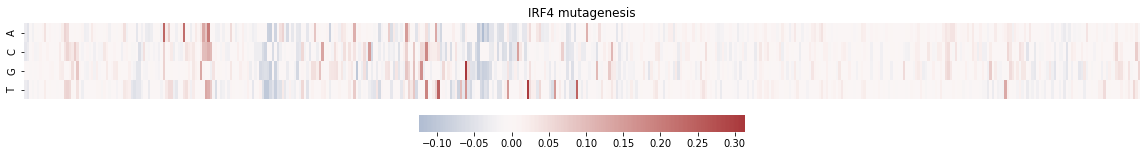

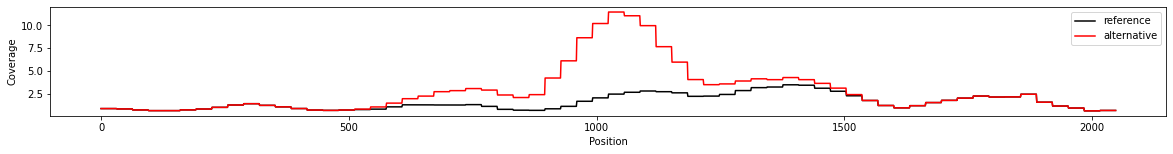

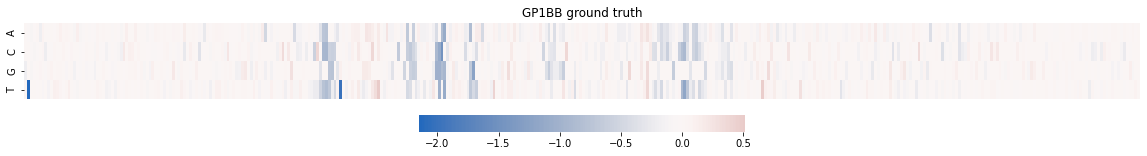

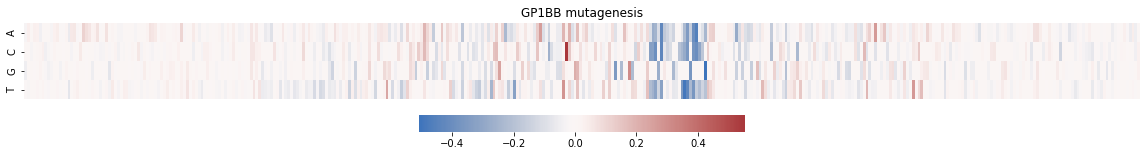

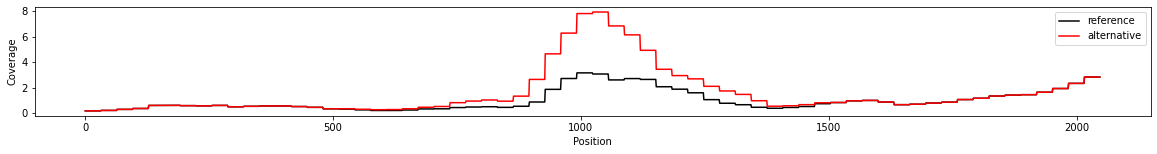

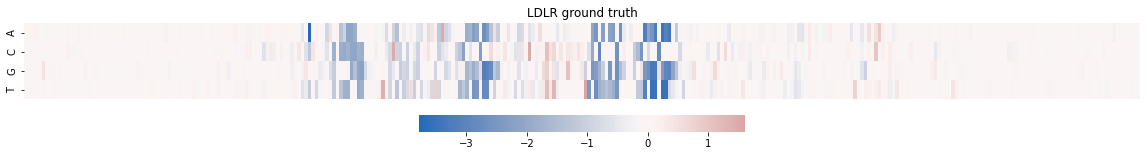

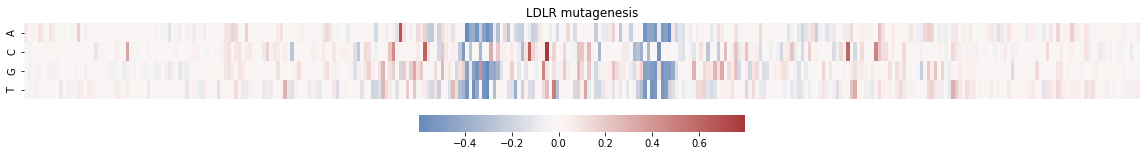

In [10]:
#visualize the largest diff per cell line
#and the heat map for saturated in silico mutagenesis
explain.visualize_vcf(ref,alt,model,average_diff,cagi_df)

## CAGI Perfomance

Result ready and plotted in heat map
Can be converted to scatter plot if needed

In [3]:
csv_list = os.listdir(eval_dir)
metadata = []
for csv_f in csv_list:
    if 'SCALES' not in csv_f and 'replicates' not in csv_f:
        metadata.append(pd.read_csv(eval_dir +csv_f))
metadata = pd.concat(metadata)

<AxesSubplot:ylabel='model'>

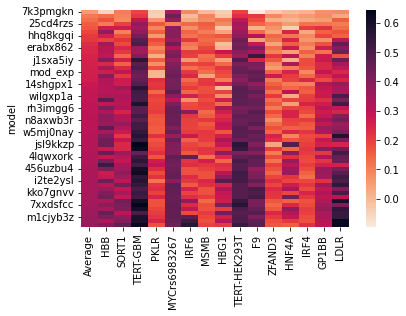

In [4]:
#compile all cagi result together
# sns.set(rc = {'figure.figsize':(15,8)})
all_result = compile_cagi_result('/home/amber/QuantPred/datasets/VCF/CAGI_results/*/*.h5',cagi_meta)
all_vcf_df = all_result.sort_values(['Average'])
sns.heatmap(all_vcf_df,cmap = sns.cm.rocket_r)


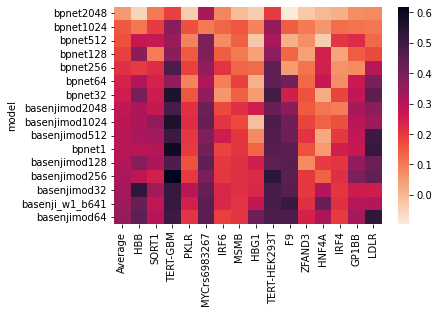

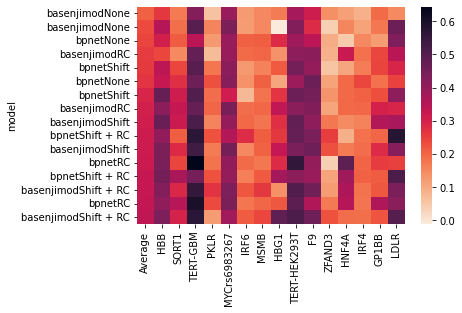

In [5]:
# across bin expeirment
bin_result = compile_cagi_result('/home/amber/QuantPred/datasets/VCF/CAGI_results/bin_size/*.h5',cagi_meta)
bin_vcf_df = bin_result.sort_values(['Average'])
bin_size = []
structure = []
for model in bin_vcf_df.index:
    metadata_entry = metadata[metadata['run_dir'].str.contains(model)]
    bin_size.append(str(metadata_entry['bin_size'].unique()[0]))
    structure.append(metadata_entry['model_fn'].unique()[0])
    
sns.heatmap(bin_vcf_df,cmap = sns.cm.rocket_r,yticklabels=np.char.add(structure, bin_size))
plt.show()
# across augemntation experiment 
aug_result = compile_cagi_result('/home/amber/QuantPred/datasets/VCF/CAGI_results/augmentation/*.h5',cagi_meta)
aug_vcf_df = aug_result.sort_values(['Average'])
aug = []
structure = []
for model in aug_vcf_df.index:
    metadata_entry = metadata[metadata['run_dir'].str.contains(model)]
    structure.append(metadata_entry['model_fn'].unique()[0])
    rev_comp = metadata_entry['rev_comp'].unique()[0]
    shift = metadata_entry['crop'].unique()[0]
    aug.append(augm_dict[(shift,rev_comp)])
    
sns.heatmap(aug_vcf_df,cmap = sns.cm.rocket_r,yticklabels=np.char.add(structure, aug))
plt.show()


## Robust VCF performance influence

In [6]:
cagi_df = pd.read_csv(cagi_meta)
diff_score = cagi_df['6']
csv_list = os.listdir(eval_dir)
metadata = []
for csv_f in csv_list:
    if 'SCALES' not in csv_f and 'replicates' not in csv_f:
        metadata.append(pd.read_csv(eval_dir +csv_f))
metadata = pd.concat(metadata)

In [7]:
df_dict = {}
for tf in cagi_df['8'].unique():
    df_dict[tf] = []
    df_dict[tf+'_n'] = []

In [8]:
VCFList = glob.glob('/home/amber/QuantPred/datasets/VCF/CAGI_no_robust/*/*.h5')

robust_average = []
no_robust_average = []
model = []
exp = []
for no_robust_result in VCFList:
    file_name = no_robust_result.split('/')[-2:]
    robust_result = os.path.join('/home/amber/QuantPred/datasets/VCF/CAGI_results',file_name[0],file_name[1])
    exp.append(file_name[0])
    
    #read robust result
    f =  h5py.File(robust_result, "r")
    total_diff = f['vcf_diff'][()]
    average_diff = np.mean(total_diff,axis = 1)
    f.close()
    
    temp_r = 0
    for tf in cagi_df['8'].unique():
        mask = (cagi_df['8'] == tf)
        cagi_diff = cagi_df[mask]['6']
        vcf_diff = average_diff[mask]
        vcf_diff = np.nan_to_num(vcf_diff)
        tf_r = scipy.stats.pearsonr(cagi_diff,vcf_diff)
        df_dict[tf].append(tf_r[0])
        temp_r += tf_r[0]
        
    robust_average.append(temp_r/15)
    
    #read no robust result
    f =  h5py.File(no_robust_result, "r")
    total_diff = f['vcf_diff'][()]
    average_diff = np.mean(total_diff,axis = 1)
    f.close()
    
    temp_r = 0
    for tf in cagi_df['8'].unique():
        mask = (cagi_df['8'] == tf)
        cagi_diff = cagi_df[mask]['6']
        vcf_diff = average_diff[mask]
        vcf_diff = np.nan_to_num(vcf_diff)
        tf_r = scipy.stats.pearsonr(cagi_diff,vcf_diff)
        df_dict[tf+'_n'].append(tf_r[0])
        temp_r += tf_r[0]
        
    no_robust_average.append(temp_r/15)

    #fill df
    file_name = robust_result.split('/')[-1]
    model.append(file_name)
   
    
df_dict['model'] = model
df_dict['average'] = robust_average
df_dict['no robust average'] = no_robust_average
df_dict['experiment'] = exp 

In [9]:
vcf_robust = pd.DataFrame.from_dict(df_dict)
vcf_robust_average = vcf_robust[['model','average','no robust average','experiment']].copy()

In [10]:
structure = []
for model in vcf_robust_average['model']:
    model = model.split('.')[0]
    metadata_entry = metadata[metadata['run_dir'].str.contains(model)]
    if len(metadata_entry)!=0:
        structure.append(metadata_entry['model_fn'].unique()[0])
    else:
        structure.append('binary')

vcf_robust_average['model_fn'] = structure
vcf_robust_average['diff'] = vcf_robust_average['average'] - vcf_robust_average['no robust average']

In [11]:
order=vcf_robust_average.sort_values(['model_fn','experiment'])['model']

/home/amber/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


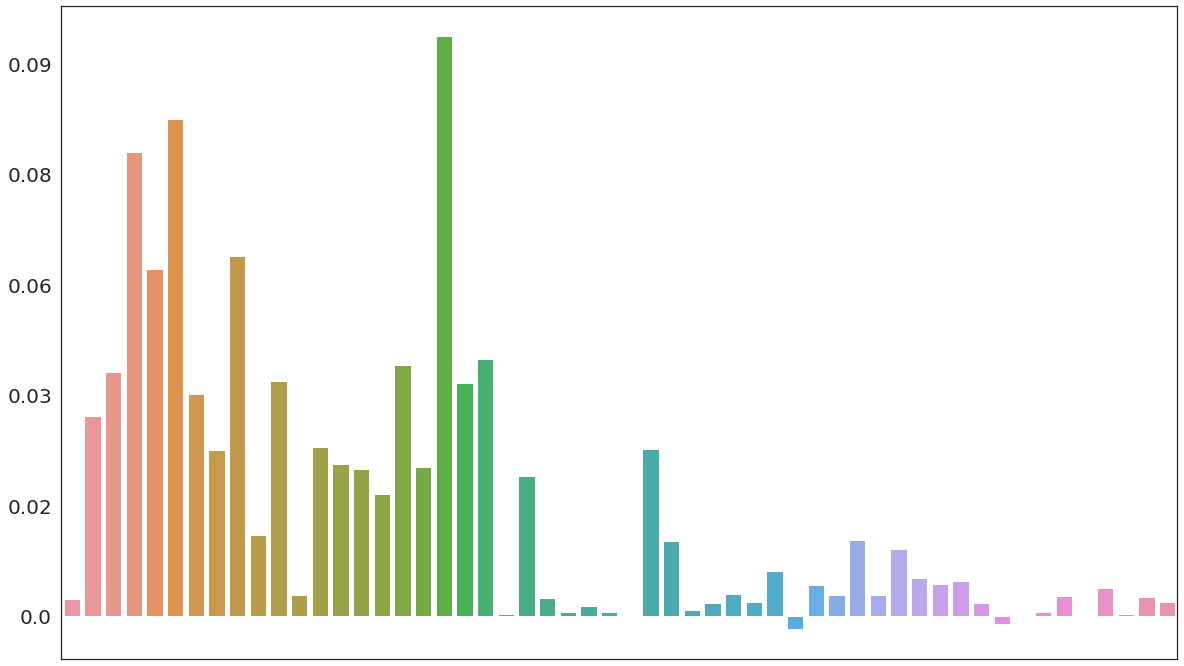

In [12]:
sns.set(rc={'figure.figsize':(20,12)})
sns.set(style='white')
fig = sns.barplot(data = vcf_robust_average, x= 'model', y = 'diff',order = order)
fig.set(xlabel='', ylabel='')
fig.set_yticklabels(fig.get_yticks().astype('U4'), size = 20)
fig.set(xticklabels=[]);

## Compare Profile vs Binary in CAGI&Performance

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import h5py
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy

In [14]:
#binary_models
rb_bi = '/home/amber/QuantPred/paper_runs/binary/mod_binary/run-20211019_161849-9ygdmjss/files/best_model.h5'
basset_bi = '/home/amber/QuantPred/paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5'
#coverage models
rb_cov = '/home/amber/QuantPred/paper_runs/coverage/rb_global_cov.h5'
basset_cov = '/home/amber/QuantPred/paper_runs/coverage/Basset_cov.h5'
#profile models
bpnet_base = '/home/amber/QuantPred/paper_runs/bpnet/augmentation_48/run-20211006_190817-456uzbu4/files/best_model.h5'
basenji_128 = '/home/amber/QuantPred/paper_runs/basenji/augmentation_basenji//run-20210924_160405-psjsjf84/files/best_model.h5'
basenji_2k = '/home/amber/QuantPred/paper_runs/basenji/binloss_basenji/run-20210920_085441-14shgpx1/files/best_model.h5'
rb_32 ='/home/amber/QuantPred/paper_runs/new_models/32_res/run-20211023_095136-to28llil/files/best_model.h5'
rb_base = '/home/amber/QuantPred/paper_runs/new_models/base_res/run-20211022_141032-m1cjyb3z/files/best_model.h5'
#model_fn_dict
model_fn_dict={rb_bi:'rb_bi',basset_bi:'basset_bi',rb_cov:'rb_cov',basset_cov:'basset_cov',bpnet_base:'bpnet_base',
             basenji_128:'basenji_128',basenji_2k:'basenji_2k',rb_32:'rb_32',rb_base:'rb_base'}

In [15]:
comp_df = pd.read_csv('/home/amber/QuantPred/datasets/binary/performance.csv',index_col = 0)
cagi_df = pd.read_csv(cagi_meta,
                      index_col=0).reset_index()

In [16]:
run_dir_list = []
for model_name in comp_df['model']:
    run_dir = globals()[model_name]
    if 'coverage' in run_dir:
        run_dir = run_dir.split('/')[-1]
        run_dir = run_dir.split('.')[0]
    elif 'binary' in run_dir:
        run_dir = run_dir.split('/')[-4]
    else:
        run_dir = run_dir.split('/')[-3]
    run_dir = run_dir.split('-')[-1]
    run_dir_list.append(run_dir)
comp_df['run_dir'] = run_dir_list

In [17]:
comparison_cagi = comp_df.merge(all_vcf_df, left_on='run_dir', right_on='model')

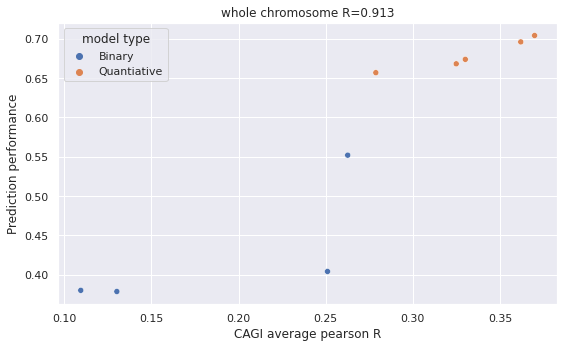

In [21]:
sns.set(rc={'figure.figsize':(8,5)})
ax = sns.scatterplot(data=comparison_cagi,x ='Average' ,y = 'chr pearson r',hue = 'model type')
ax.set_xlabel('CAGI average pearson R')
ax.set_ylabel('Prediction performance')
ax.set_title('whole chromosome R=' + "%.3f"%scipy.stats.pearsonr(comparison_cagi['chr pearson r'],comparison_cagi['Average'])[0])
plt.tight_layout()
plt.show()